In [106]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from mlxtend.plotting import plot_decision_regions

### Scatter matrix

In [107]:
def scatter_matrix(X):
    """
    Computes the scatter matrix of a data matrix X.

    Parameters
    ----------
    X : numpy.ndarray
        A 2D numpy array where the rows are the samples and the columns are the features.
    
    Returns
    -------
    numpy.ndarray
        The scatter matrix of X.
    """
    num_features = X.shape[1]
    S = np.zeros((num_features, num_features))
    X_bar = np.mean(X, axis=0)
    for j in range(X.shape[0]):
        S += (X[j] - X_bar).reshape(-1,1) @ (X[j, :] - X_bar).reshape(1,-1)
    return S

# [LDA](https://www.sciencedirect.com/topics/computer-science/linear-discriminant-analysis#:~:text=Linear%20Discriminant%20Analysis%20(LDA)%20is,Principal%20Component%20Analysis%20(PCA).)

--------------

**Algorithm 1.3** Linear Discriminant Analysis

--------------

1. Estandarizar el conjunto de datos de dimensión $d$
2. Para cada clase, calcular su vector de medias (de dimensión $d$)
3. Obtener la matriz de dispersión (*scatter matrix*) entre las clases $S_B$ y la matriz de dispersión de la propia clase $S_W$
4. Determinar los eigenvalores y eigenvectores correspondientes a la matriz $S_W^{-1}S_B$
5. Ordenar los eigenvalores de manera decreciente con sus correspondientes eigenvectores
6. Seleccionar los $k$ eigenvectores que corresponden con los $k$ mayores eigenvalores para contruir una $d \times k$-dimensional matriz de proyección $\mathbf{W}$; los eigenvectores son las columnas de dicha matriz
7. Proyectar las muestras sobre el nuevo subespacio de características utilizando la matriz de proyección $\mathbf{W}$

In [108]:
class LDA:
    def __init__(self, n_components):
        self.n_components = n_components
        self.W = None

    def fit(self, X, y):
        """
        Ajusta el modelo LDA.
        Calcula las matrices de dispersión intra-clase (Sw) y entre-clases (Sb),
        y obtiene los vectores propios más importantes.
        """
        # Estandarizar los datos
        X_std = StandardScaler().fit_transform(X)

        # Calcular Sw y Sb
        Sw = np.zeros((X.shape[1], X.shape[1]))  # Matriz de dispersión intra-clase
        Sb = np.zeros((X.shape[1], X.shape[1]))  # Matriz de dispersión entre-clases
        mu_global = np.mean(X_std, axis=0)  # Media global
        clases = np.unique(y)

        for clase in clases:
            X_clase = X_std[y == clase]  # Datos de una clase específica
            mu_clase = np.mean(X_clase, axis=0)  # Media de la clase
            Sw += scatter_matrix(X_clase)
            n_clase = X_clase.shape[0]
            Sb += n_clase * (mu_clase - mu_global).reshape(-1, 1) @ (mu_clase - mu_global).reshape(1, -1)

        # Calcular valores y vectores propios
        eig_vals, eig_vecs = np.linalg.eig(np.linalg.inv(Sw).dot(Sb))

        # Ordenar los vectores propios por su valor propio en orden descendente
        eig_pairs = [(np.abs(eig_vals[i]), np.real(eig_vecs[:, i])) for i in range(len(eig_vals))]
        eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

        # Guardar los n_components vectores propios en W
        self.W = np.hstack([eig_pairs[i][1].reshape(X.shape[1], 1) for i in range(self.n_components)])

    def transform(self, X):
        """
        Transforma los datos X utilizando la matriz W obtenida del ajuste (fit).
        """
        if self.W is None:
            raise ValueError("El modelo no está ajustado. Llama primero a 'fit'.")

        # Estandarizar los datos de entrada
        X_std = StandardScaler().fit_transform(X)

        # Proyectar los datos en los componentes seleccionados
        return X_std @ self.W

#### Ejemplo con datos aleatorios y una componente

In [109]:
X_class1 = np.random.multivariate_normal([2, 2], [[0.5, 0.2], [0.2, 0.5]], 50)
X_class2 = np.random.multivariate_normal([4, 4], [[0.5, -0.2], [-0.2, 0.5]], 50)
X = np.vstack((X_class1, X_class2))
y = np.hstack((np.zeros(50), np.ones(50)))

# Inicializar LDA con 1 componente
lda = LDA(n_components=1)

# Ajustar el modelo con los datos de entrenamiento
lda.fit(X, y)

# Transformar los datos de entrenamiento
X_lda = lda.transform(X)

In [110]:
def plot_results(X_class1, X_class2, X_lda):
    """
    Función para graficar los resultados del análisis LDA.
    """
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(X_class1[:, 0], X_class1[:, 1], color='red', label='Clase 1')
    plt.scatter(X_class2[:, 0], X_class2[:, 1], color='blue', label='Clase 2')
    plt.title('Datos Originales')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(X_lda[:50,], np.zeros(50), color='red', label='Clase 1')
    plt.scatter(X_lda[50:], np.zeros(50), color='blue', label='Clase 2')
    plt.title('Datos Proyectados con LDA')
    plt.xlabel('Nueva dimensión (LDA)')
    plt.yticks([])
    plt.legend()

    plt.tight_layout()
    plt.show()

In [111]:
X_lda.shape

(100, 1)

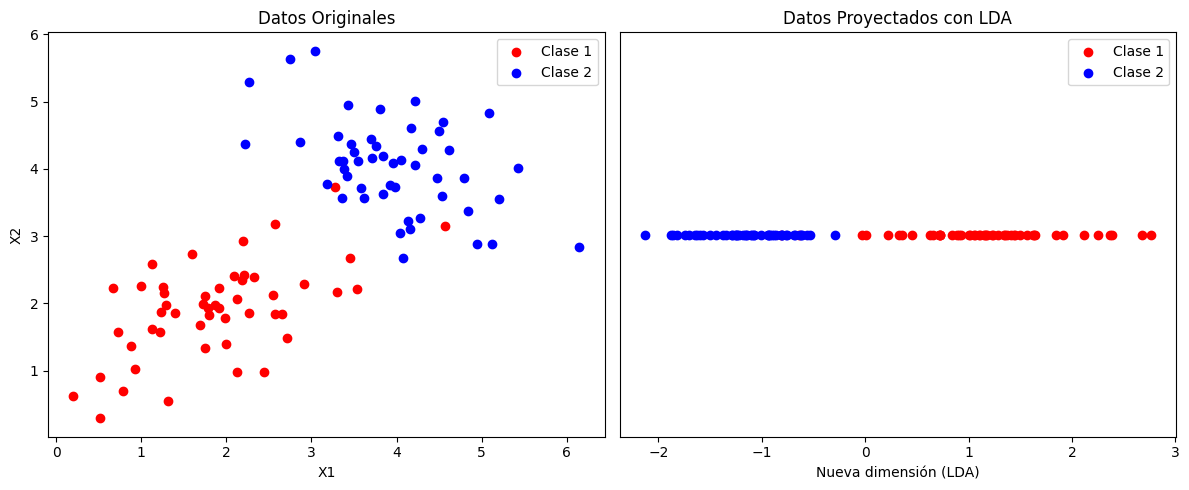

In [112]:
plot_results(X_class1, X_class2, X_lda)

#### Ejemplo con datos de vinos y 2 componentes

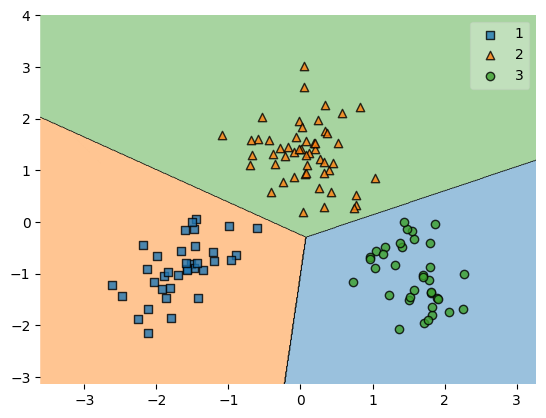

In [113]:
df_wine = pd.read_csv('https://bit.ly/3L1ZZI4', header = None)
# Separación de las características y las etiquetas
X, y = df_wine.iloc[:, 1:].values, df_wine.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Inicializar LDA con 2 componentes
lda2 = LDA(n_components=2)

# Ajustar el modelo con los datos de entrenamiento
lda2.fit(X_train, y_train)

# Transformar los datos de entrenamiento y prueba
X_train_lda = lda2.transform(X_train)
X_test_lda = lda2.transform(X_test)

# Entrenar un modelo de regresión logística con los datos transformados
lr = LogisticRegression()
lr.fit(X_train_lda, y_train)

# Visualizar las regiones de decisión con el conjunto de entrenamiento reducido
plot_decision_regions(X_train_lda, y_train, clf=lr)
plt.show()

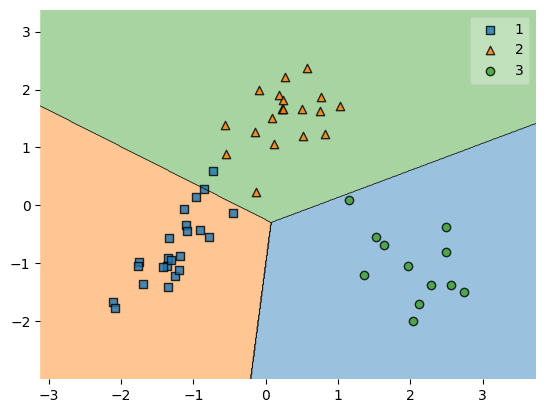

In [114]:
# Visualizar las regiones de decisión con el conjunto de pruebas
plot_decision_regions(X_test_lda, y_test, clf=lr)
plt.show()

In [115]:
lr.score(X_test_lda,y_test)

0.9814814814814815